<a href="https://colab.research.google.com/github/DS5500T9/Solar-Irradiance-Prediction/blob/main/Modelling/Model%201%20-%20Prophet/Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
#importing necessary libraries

import pandas as pd
import numpy as np
from datetime import datetime

import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score

from prophet import Prophet

#DATASET ANALYSIS

In [11]:
data = pd.read_csv("/content/drive/MyDrive/Numerical Dataset Curation/Meteorological_Data.csv")

In [16]:
data.head(1)

,DATETIME,Avg BRBG Total Cloud Cover [%],Avg CDOC Total Cloud Cover [%],Avg CDOC Thick Cloud Cover [%],Avg CDOC Thin Cloud Cover [%],Avg Sun Flag,Avg HCF Value,Avg Blue/Red_min,Avg Blue/Red_mid,Avg Blue/Red_max,...,Avg Zenith Angle [degrees],Avg Azimuth Angle [degrees],Avg Solar Eclipse Shading,Avg Tower Dew Point Temp [deg C],Avg Total Cloud Cover [%],Avg Opaque Cloud Cover [%],Avg Avg Wind Speed @ 6ft [m/s],Avg Precipitation [mm],Avg Moisture,Avg Albedo (CMP11)
Timestamp,,,,,,,,,,,,,,,,,,,,,
2021-10-08 07:00:00,2021-10-08 07:00:00,13.6667,36.8333,0.0,36.8333,8.0,1.0367,0.9617,1.585,3.1533,...,85.6866,101.5014,0,-1.122,19.9667,10.4667,2.1028,0.0,0.0,0.2815


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8888 entries, 2021-10-08 07:00:00 to 2023-10-09 17:00:00
Data columns (total 22 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   DATETIME                             8888 non-null   object 
 1   Avg BRBG Total Cloud Cover [%]       8888 non-null   float64
 2   Avg CDOC Total Cloud Cover [%]       8888 non-null   float64
 3   Avg CDOC Thick Cloud Cover [%]       8888 non-null   float64
 4   Avg CDOC Thin Cloud Cover [%]        8888 non-null   float64
 5   Avg Sun Flag                         8888 non-null   float64
 6   Avg HCF Value                        8888 non-null   float64
 7   Avg Blue/Red_min                     8888 non-null   float64
 8   Avg Blue/Red_mid                     8888 non-null   float64
 9   Avg Blue/Red_max                     8888 non-null   float64
 10  Avg File Extension                   8888 non-null   float64

#PREPROCESSING

In [12]:
def preprocess_dataframe(df):
  """
  params:
  - df (dataframe): dataframe before preprocessing
  does:
  - Transform 'DATETIME' column from object to datetime format with renaming of column to timestamp.
  - Remove Outliers
  -Timestamp can be changed to index
  returns: Processed df (dataframe)
  """
  df['Timestamp'] = pd.to_datetime(df['DATETIME'])
  df.set_index('Timestamp', inplace=True) # set timestamp as index
  df=df.drop(['DATETIME', 'Avg Solar Eclipse Shading'], axis=1) # Remove null columns
  df = df[df["Avg CDOC Total Cloud Cover [%]"] !=-99999 ] # remove outliers
  return df

In [13]:
df=preprocess_dataframe(data)

#FEATURE SELECTION

###Random Forest Regressor

In [21]:
#Create X & Y
X = df.drop('Avg Global CMP22 (vent/cor) [W/m^2]', axis=1)
# Define the target variable
y = df['Avg Global CMP22 (vent/cor) [W/m^2]']

In [27]:
# Create a Random Forest Regressor
Feature = RandomForestRegressor(n_estimators=100, random_state=42)

In [28]:
#Train
Feature.fit(X, y)

RandomForestRegressor(random_state=42)

In [29]:
# Get feature importances
feature_importances = Feature.feature_importances_
# Get the names of the features
feature_names = X.columns
# Sort the feature importances in descending order
sorted_idx = feature_importances.argsort()[::-1]
#Printing the Features
print("Feature ranking:")
for i in range(len(sorted_idx)):
    print(f"{i + 1}. Feature '{feature_names[sorted_idx[i]]}' ({feature_importances[sorted_idx[i]]})")

Feature ranking:
1. Feature 'Avg Zenith Angle [degrees]' (0.711676853954419)
2. Feature 'Avg Sun Flag' (0.19765764914799114)
3. Feature 'Avg Opaque Cloud Cover [%]' (0.026599596252951132)
4. Feature 'Avg Blue/Red_min' (0.023433460938002023)
5. Feature 'Avg BRBG Total Cloud Cover [%]' (0.007625086897657689)
6. Feature 'Avg Albedo (CMP11)' (0.005119917021154582)
7. Feature 'Avg Tower Dew Point Temp [deg C]' (0.0048628996228067736)
8. Feature 'Avg Total Cloud Cover [%]' (0.004115140587297173)
9. Feature 'Avg Azimuth Angle [degrees]' (0.003259371051480165)
10. Feature 'Avg Moisture' (0.0025836758806117186)
11. Feature 'Avg CDOC Total Cloud Cover [%]' (0.0023181755437306213)
12. Feature 'Avg Avg Wind Speed @ 6ft [m/s]' (0.0020149559570444638)
13. Feature 'Avg Blue/Red_mid' (0.002006201686007651)
14. Feature 'Avg Blue/Red_max' (0.0018984342275792418)
15. Feature 'Avg CDOC Thin Cloud Cover [%]' (0.0017791712973268753)
16. Feature 'Avg HCF Value' (0.001585757949694675)
17. Feature 'Avg CDOC Th

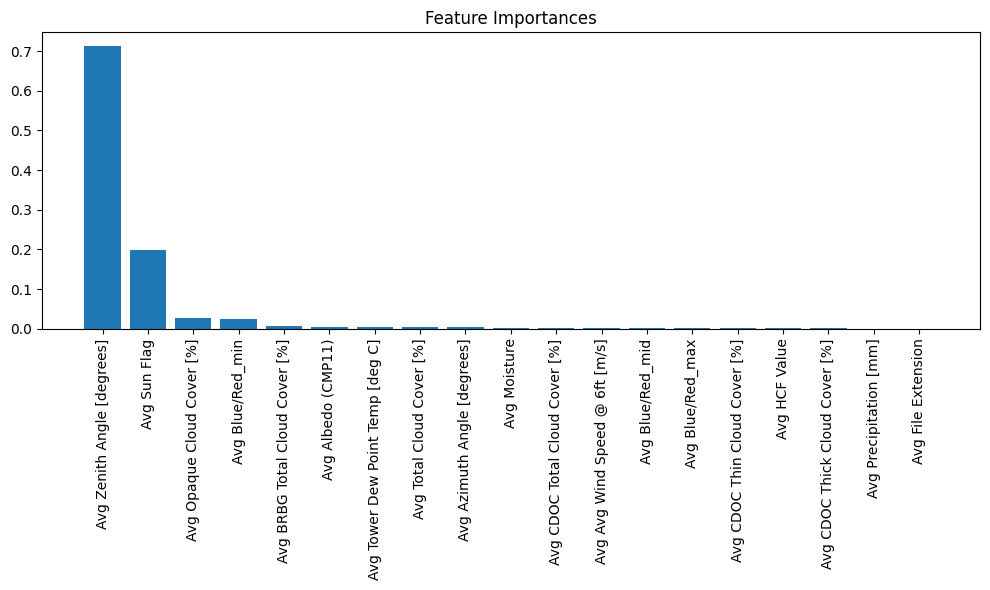

In [31]:
# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(sorted_idx)), feature_importances[sorted_idx], align="center")
plt.xticks(range(len(sorted_idx)), feature_names[sorted_idx], rotation=90)  # Added a closing parenthesis here
plt.tight_layout()
plt.show()

# Selecting Features based on above and Modeling

In [46]:
#Selecting certain columns and dropping the rest
cols_to_keep = ['Avg Zenith Angle [degrees]','Avg Sun Flag','Avg Opaque Cloud Cover [%]','Avg Blue/Red_min','Avg Global CMP22 (vent/cor) [W/m^2]']
#data_df=X.loc[:, cols_to_keep]
data_df=df.loc[:, cols_to_keep]

In [49]:
data_df.head()

,Timestamp,Avg Zenith Angle [degrees],Avg Sun Flag,Avg Opaque Cloud Cover [%],Avg Blue/Red_min,Avg Global CMP22 (vent/cor) [W/m^2]
0,2021-10-08 07:00:00,85.6866,8.0,10.4667,0.9617,63.8407
1,2021-10-08 08:00:00,74.7881,3.5,47.8667,0.9333,176.1522
2,2021-10-08 09:00:00,64.6156,3.0,77.2333,0.9267,361.7695
3,2021-10-08 10:00:00,55.8601,3.0,39.2167,0.9367,582.2481
4,2021-10-08 11:00:00,49.3991,3.0,69.2000,0.9850,632.4995


In [48]:
data_df = data_df.reset_index()

In [50]:
data_df = data_df.rename(columns={"Timestamp": "ds", "Avg Global CMP22 (vent/cor) [W/m^2]": "y"})

In [51]:
data_df.head(1)

,ds,Avg Zenith Angle [degrees],Avg Sun Flag,Avg Opaque Cloud Cover [%],Avg Blue/Red_min,y
0,2021-10-08 07:00:00,85.6866,8.0,10.4667,0.9617,63.8407


In [54]:
#TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(data_df):
    train = data_df.iloc[train_index]
    valid = data_df.iloc[test_index]

In [56]:
#initialize the model
model = Prophet(
    seasonality_mode='multiplicative',
    seasonality_prior_scale=0.1
)

In [57]:
model.fit(train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp93gqlucd/0up3al_y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp93gqlucd/kehe7bzx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13791', 'data', 'file=/tmp/tmp93gqlucd/0up3al_y.json', 'init=/tmp/tmp93gqlucd/kehe7bzx.json', 'output', 'file=/tmp/tmp93gqlucd/prophet_modelj3064rtk/prophet_model-20231021194733.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:47:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:47:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [62]:
valid.head()

,ds,Avg Zenith Angle [degrees],Avg Sun Flag,Avg Opaque Cloud Cover [%],Avg Blue/Red_min,y
7324,2023-06-27 19:00:00,80.0444,6.6667,6.8500,0.8967,122.0784
7325,2023-06-27 20:00:00,90.2606,8.0000,0.0333,0.8583,10.1054
7326,2023-06-28 05:00:00,91.4115,8.0000,-0.7167,0.9017,4.3003
7327,2023-06-28 06:00:00,81.2640,5.8333,12.6333,0.9750,96.4975
7328,2023-06-28 07:00:00,70.4254,5.0000,12.3500,0.9867,287.7524


In [58]:
forecast = model.predict(valid)

In [63]:
forecast[['ds','yhat','yhat_lower','yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2023-06-27 19:00:00,14.512129,-193.519348,202.027259
1,2023-06-27 20:00:00,5.096893,-192.829007,208.176984
2,2023-06-28 05:00:00,9.228853,-200.149131,211.278863
3,2023-06-28 06:00:00,19.512973,-184.868089,217.956854
4,2023-06-28 07:00:00,109.632503,-100.167121,308.072574


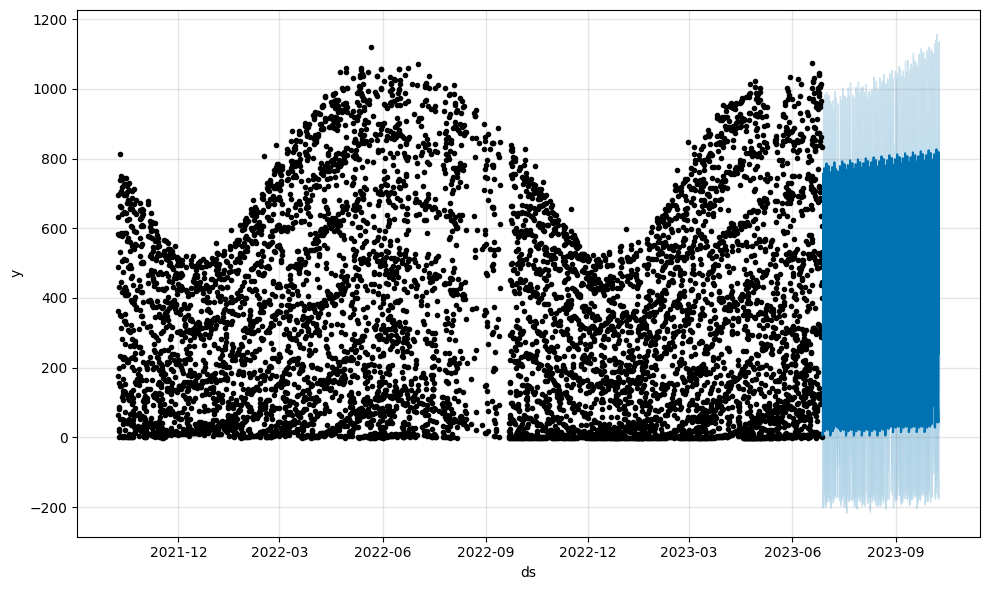

In [64]:
fig = model.plot(forecast)

#EVALUATION

In [67]:
forecasted_values = forecast[['ds', 'yhat']]

In [68]:
forecasted_values.rename(columns={'ds': 'ds', 'yhat': 'forecasted_y'}, inplace=True)

<ipython-input-68-9280924d442f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecasted_values.rename(columns={'ds': 'ds', 'yhat': 'forecasted_y'}, inplace=True)


In [69]:
merged_df = pd.merge(valid, forecasted_values, on='ds', how='inner')

In [70]:
merged_df.head()

,ds,Avg Zenith Angle [degrees],Avg Sun Flag,Avg Opaque Cloud Cover [%],Avg Blue/Red_min,y,forecasted_y
0,2023-06-27 19:00:00,80.0444,6.6667,6.8500,0.8967,122.0784,14.512129
1,2023-06-27 20:00:00,90.2606,8.0000,0.0333,0.8583,10.1054,5.096893
2,2023-06-28 05:00:00,91.4115,8.0000,-0.7167,0.9017,4.3003,9.228853
3,2023-06-28 06:00:00,81.2640,5.8333,12.6333,0.9750,96.4975,19.512973
4,2023-06-28 07:00:00,70.4254,5.0000,12.3500,0.9867,287.7524,109.632503


In [71]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calculate evaluation metrics
y_true = merged_df['y']
y_pred = merged_df['forecasted_y']

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 226.6331336745059
Mean Squared Error (MSE): 102256.06657451602
Root Mean Squared Error (RMSE): 319.7750249386528


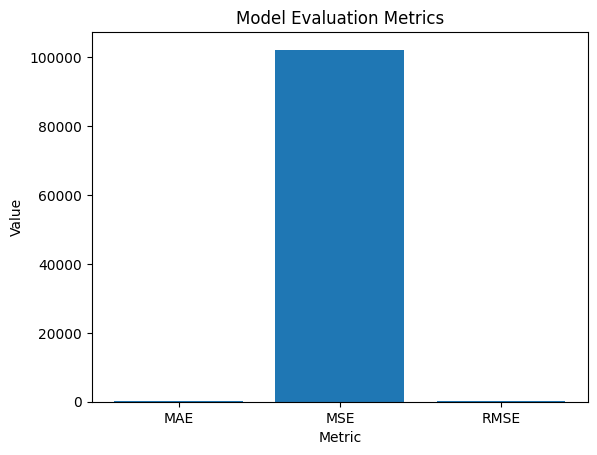

In [72]:
import matplotlib.pyplot as plt

# Create a bar plot of evaluation metrics
metrics = ['MAE', 'MSE', 'RMSE']
values = [mae, mse, rmse]

plt.bar(metrics, values)
plt.title('Model Evaluation Metrics')
plt.xlabel('Metric')
plt.ylabel('Value')
plt.show()